In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS
import kvn

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

8701
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
for i in range(30):
    plt.close()

In [3]:
# -----------------------------------------------------------------------
# --- Periodic boundary conditions ---
# -----------------------------------------------------------------------
def der_first(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - y[ii-1]
        else:
            y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der
# -----------------------------------------------------------------------
def der_second(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - 2. * y[ii] + y[ii - 1]
        else:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[ii - 1]
    y_der /= (dx**2)
    return y_der
# -----------------------------------------------------------------------
def plot_tx(x, t, y):
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    cmap_two_signs_= 'coolwarm'
    fontsize = 16
    linewidth = 4

    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    fig_tx = plt.figure(figsize=(8, 6))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(y), levels=100, cmap=cmap_two_signs_, norm=divnorm)
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title('$y(t,x)$', fontsize = fontsize)
    ax.set_xlim(0, np.max(t))
    ax.set_ylim(0, np.max(x))
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    return

v	 1.0
D	 0.0
Nx	 64
Nt	 4096
--- Stability criteria ---
current dx, dt:	 1.587e-02, 4.884e-04
maximum dx, dt:	 2.000e-02, 1.260e-02
Courant number: 0.0308


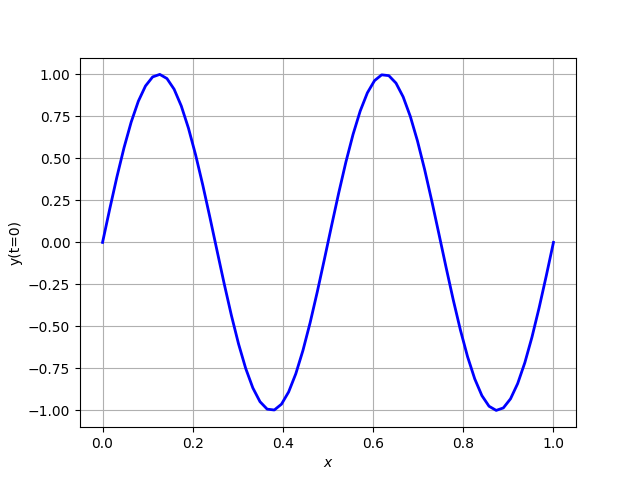

spectral norm.: 1.588e+02
Matrix Ah:	 nonsparsity, coefnorm: 3, 2.917e+02
Matrix Aa:	 nonsparsity, coefnorm: 2, 8.910e+01


In [4]:
# ---------------------------------------------------------------------
# --- Diffusion-convection equation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(LCHS)

flag_RG = True
flag_init_sin = True

nx, nt = 6, 12
xmax, tmax = 1.0, 2.0
v = 1.0
D = 0.01

# --- Grids ---
Nx = 1 << nx
Nt = 1 << nt
x = np.linspace(0, xmax, Nx)
t = np.linspace(0, tmax, Nt)
dt = np.diff(t)[0]
dx = np.diff(x)[0]

print("v\t {:0.1f}".format(v))
print("D\t {:0.1f}".format(D))
print("Nx\t {:d}".format(Nx))
print("Nt\t {:d}".format(Nt))

print("--- Stability criteria ---")
dx_max = 2. * D / v
dt_max = dx**2 / (2. * D)
print("current dx, dt:\t {:0.3e}, {:0.3e}".format(dx, dt))
print("maximum dx, dt:\t {:0.3e}, {:0.3e}".format(dx_max, dt_max))
print("Courant number: {:0.3}".format(v * dt/ dx))

# --- signal ---
y = np.zeros((Nt, Nx))

# --- initial condition ---
Lw = 0.5*xmax
kw = 2.*np.pi / Lw

if flag_init_sin:
    y[0,:] = np.sin(kw * x)
else:
    y[0,:] = np.exp( - (x - xmax/2.)**2/(2. * 0.05**2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y[0, :], color='blue', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.ylabel("y(t=0)")
plt.grid(True)
plt.show()

# --------------------------------------------------------
# --- Form the matrix for the DC equation ---
# --------------------------------------------------------
def get_A_DC():
    A = np.zeros((Nx, Nx))
    beta = 1. / (dx**2)
    sigma = 1. / (2.*dx)
    coef_r = D * beta - v * sigma
    coef_c = -2. * D * beta
    coef_l = D * beta + v * sigma
    for ir in range(Nx):
        ic_l = ir - 1
        ic_r = ir + 1
        if ir == 0:
            ic_l = Nx - 1
        if ir == (Nx - 1):
            ic_r = 0

        A[ir, ic_l] = coef_l
        A[ir, ir]   = coef_c
        A[ir, ic_r] = coef_r

    sp_norm = np.linalg.norm(A, ord=2)
    print("spectral norm.: {:0.3e}".format(sp_norm))
    return -A
# ------------------------------------------------------------------------

# --- matrix ---
A_ = get_A_DC()
Ah_, Aa_ = mix.get_herm_aherm_parts(A_)
_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

# --- initial state ---
psi_init = y[0,:]

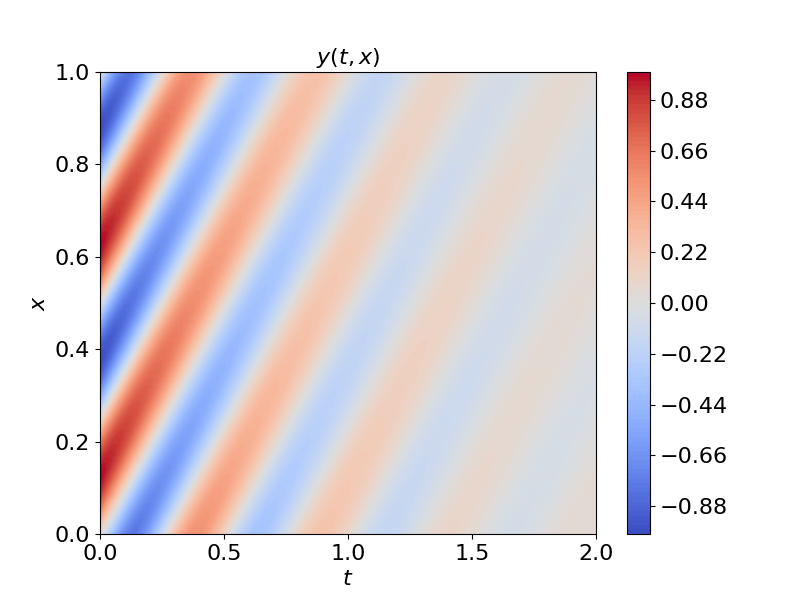

In [18]:
# ---------------------------------------------------------------------
# --- Reference classical simulation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)

# --- chosen derivative method ---
def func_RHS(yx_new):
    dx_y  = der_first(yx_new, dx)
    d2x_y = der_second(yx_new, dx) 
    RK = - v * dx_y + D * d2x_y
    return RK


# --- first-order der. in time ---
if not flag_RG:
    for it in range(Nt-1):
        t1 = t[it]
        yx = y[it,:]
        y[it+1,:] = yx + dt * func_RHS(yx)
# --- 4-th order Runge-Kutta ---
else:
    dt2 = dt/2.
    dt6 = dt/6.
    for it in range(Nt-1):
        t1 = t[it]
        yx = y[it,:]

        # --- Step 1 ---
        RK_k1 = func_RHS(yx)

        # --- Step 2 ---
        yx_new = yx + dt2 * RK_k1
        RK_k2 = func_RHS(yx_new)

        # --- Step 3 ---
        yx_new = yx + dt2 * RK_k2
        RK_k3 = func_RHS(yx_new)

        # --- Step 4 ---
        yx_new = yx + dt * RK_k3
        RK_k4 = func_RHS(yx_new)

        # --- Next time point ---
        y[it+1,:] = y[it,:] + dt6 * (RK_k1 + 2.*RK_k2 + 2.*RK_k3 + RK_k4)

# --- Plot(t,x) ---
plot_tx(x, t, y)

del t1

# v, D: 1, 1.0
# current dx, dt:	 1.587e-02, 1.221e-04
# maximum dx, dt:	 2.000e+00, 1.260e-04

# v, D: 10, 1.0
# current dx, dt:	 1.587e-02, 1.221e-04
# maximum dx, dt:	 2.000e-01, 1.260e-04

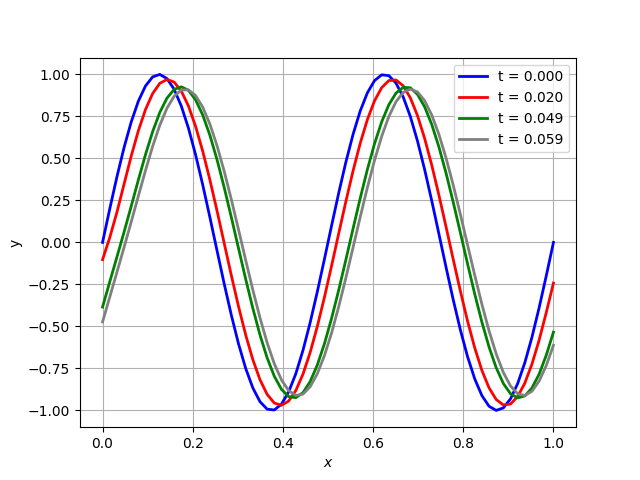

In [6]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
# t_moments = [0, 10, 20]
t_moments = [0, 40, 100, 120]

fig = plt.figure()
ax = fig.add_subplot(111)
for it in range(len(t_moments)):
    id_t = t_moments[it]
    ax.plot(
        x, y[id_t, :], 
        color=colors_[it], linewidth = 2, linestyle='-',  
        label = "t = {:0.3f}".format(t[id_t])
    )
plt.xlabel('$x$')
plt.ylabel("y")
ax.legend()
plt.grid(True)
plt.show()

In [18]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(LCHS)

def computation_LCHS_py():
    t_LCHS = 0.5

    n_dk, coef_trot = 4, 100.0

    #      for n_dk = 0
    # *** nk = 4  --> kmax = 5 ***
    # *** nk = 5  --> kmax = 10 ***
    # *** nk = 6  --> kmax = 20 ***
    # *** nk = 7  --> kmax = 40 ***
    nk = 5 + n_dk

    # ---------------------
    Nk = 1<<nk
    
    print()
    print("LCHS-python computation: nk: ", nk)

    # dk = LCHS.get_dk(None, None, None, n_dk)
    dk = LCHS.get_dk(norm_Ah_, norm_Aa_, t_LCHS, n_dk)

    k_max_py = 0.5 * dk * (Nk - 1)
    k_grid = np.linspace(-k_max_py, k_max_py, Nk)
    print("dk, kmax: {:0.3e}, {:0.3f}".format(dk, k_max_py))

    tau, N_steps = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS, coef_trot, k_max_py)
    t_LCHS = tau * N_steps # correct the time moment for the LCHS
    print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t_LCHS, tau, N_steps))

    psi_LCHS_py = kvn.LCHS_computation(
        k_grid, tau,
        A_, psi_init, N_steps, 
        flag_trotterization = True, 
        flag_print = False
    )
    print("Done.")
    return psi_LCHS_py, t_LCHS
# ------------------------------------------------------------------------

psi_LCHS_py_, t_LCHS_ = computation_LCHS_py()

# --- interpolate reference simulations ---
y_interp = np.zeros(Nx)
for ix in range(Nx):
    y_interp[ix] = np.interp(t_LCHS_, t, y[:,ix]) 

# --- maximum error ---
max_abs_err = np.max(np.abs(y_interp - psi_LCHS_py_))
max_rel_err = np.max(np.abs(y_interp - psi_LCHS_py_) / np.abs(y_interp))
print("max. abs. error: {:0.3}".format(max_abs_err))
print("max. rel. error: {:0.3}".format(max_rel_err))


LCHS-python computation: nk:  9
dk, kmax: 3.914e-02, 10.000
t, tau, N_steps: 4.800e-01, 3.429e-02, 14
Done.
max. abs. error: 0.0061
max. rel. error: 0.0132


In [ ]:
# LCHS-python computation: nk:  11
# dk, kmax: 3.914e-02, *40.059*
# t, tau, N_steps: 4.964e-01, 8.559e-03, 58
# Done.
# max. abs. error: 0.000499
# max. rel. error: 0.00433



# LCHS-python computation: nk:  _10_
# dk, kmax: _3.914e-02_, *20.020*
# t, tau, N_steps: 5.000e-01, 1.713e-02, 29
# Done.
# max. abs. error: 0.00131
# max. rel. error: 0.00763



# LCHS-python computation: nk:  _8_
# dk, kmax: _1.575e-01_, 20.079
# t, tau, N_steps: 4.952e-01, 1.708e-02, 29
# Done.
# max. abs. error: 0.00402
# max. rel. error: 0.0947



# LCHS-python computation: nk:  10
# dk, kmax: 3.914e-02, 20.020
# t, tau, N_steps: 5.000e-01, 1.713e-03, 291
# Done.
# max. abs. error: 0.00122
# max. rel. error: 0.0188


# LCHS-python computation: nk:  10
# dk, kmax: 3.914e-02, 20.020
# t, tau, N_steps: 4.999e-01, 1.713e-04, 2919
# Done.
# max. abs. error: 0.00114
# max. rel. error: 0.0138


/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


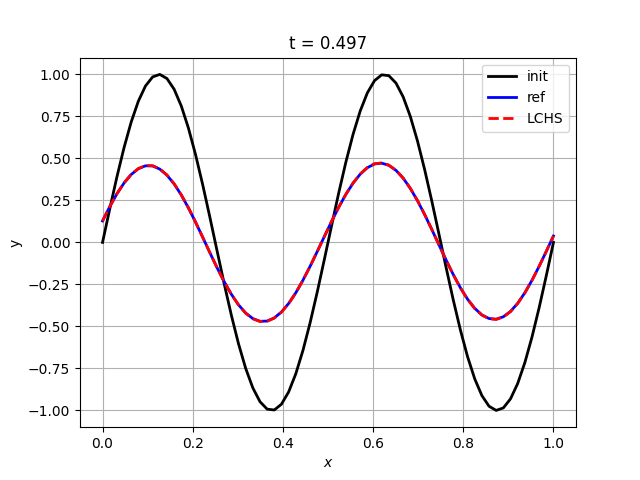

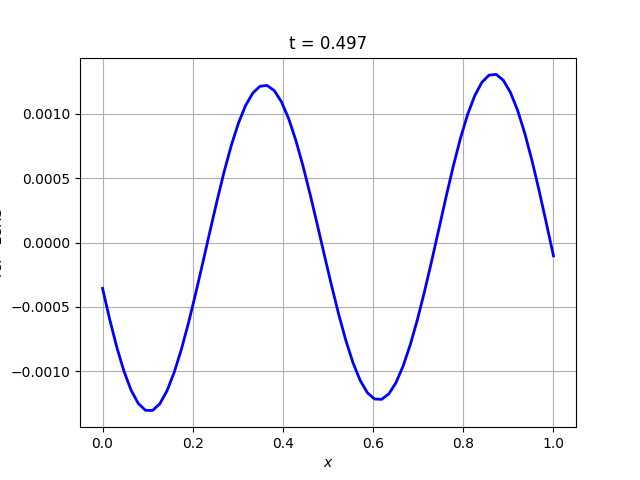

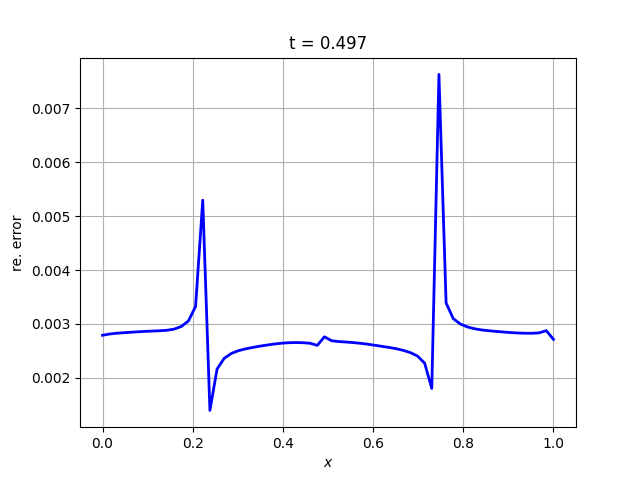

In [8]:
# --------------------------------------------------
# --- Compare reference and LCHS-py simulations  ---
# --------------------------------------------------

# --- Plotting signals ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y[0,:],       "black",  linewidth = 2, label = "init")
ax.plot(x, y_interp,     "-b",  linewidth = 2, label = "ref")
ax.plot(x, psi_LCHS_py_, "--r", linewidth = 2, label = "LCHS")
plt.xlabel('$x$')
plt.ylabel("y")
plt.title("t = {:0.3f}".format(t_LCHS_))
ax.legend()
plt.grid(True)
plt.show()

# --- Plotting errors ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_interp - psi_LCHS_py_, "-b",  linewidth = 2)
# ax.plot(x, np.abs(y_interp - psi_LCHS_py_)/np.abs(y_interp) / 10, "-r",  linewidth = 2)
plt.xlabel('$x$')
plt.ylabel("ref - LCHS")
plt.title("t = {:0.3f}".format(t_LCHS_))
plt.grid(True)
plt.show()

# --- Plotting relative errors ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, np.abs(y_interp - psi_LCHS_py_)/np.abs(y_interp), "-b",  linewidth = 2)
plt.xlabel('$x$')
plt.ylabel("re. error")
plt.title("t = {:0.3f}".format(t_LCHS_))
plt.grid(True)
plt.show()

In [29]:
# ------------------------------------------------------------
# --- Initial parameters for the LCHS-QuCF simulation ---
# ------------------------------------------------------------

k_max_, nk_init_, n_dk_, coef_trot_ = 10, 5, 4, 100.0
nk_ = nk_init_ + n_dk_

t_LCHS_qucf_ = 0.10
flag_AA_ = True

# --- Fourier k-grid ---
Nk_ = 1 << nk_
dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)
k_max_ = 0.5 * dk_ * (Nk_ - 1)

# --- Path with the QuCF simulation ---
if D == 0.01:
    name_pr_ = "D001"
else:
    name_pr_ = None
    print("!!! ERROR: no QuCF simulations for D = {:0.3e}".format(D))
path_root_ = "../QuCF/simulations/LCHS/DiffConv/"
path_qucf_ = path_root_ + "{:s}".format(name_pr_)

# --- Print parameters ---
print("Chosen parameters for the LCHS-QuCF simulation")
print("kmax, nk, dk:\t {:0.3f}, {:d}, {:0.3e}".format(k_max_, nk_, dk_))
if flag_AA_:
    print("with the AA of the LCHS weights")
else:
    print("without the AA of the LCHS weights")
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))

Chosen parameters for the LCHS-QuCF simulation
kmax, nk, dk:	 10.000, 9, 3.914e-02
with the AA of the LCHS weights
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/DiffConv/D001


In [30]:
# ------------------------------------------------------------
# --- Parameters for the BE ---
# ------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def print_values(name_B, B, ir = 1):
    ic_l = ir - 1
    ic_r = ir + 1
    if ir == 0:
        ic_l = Nx - 1
    if ir == Nx - 1:
        ic_r = 0
    vl, vc, vr = B[ir, ic_l], B[ir, ir], B[ir, ic_r]
    print("{:s}: vl, vc, vr:\t {:20.3e}, {:20.3e}, {:20.3e}".format(name_B, vl, vc, vr))
    return
# -------------------------------------------------------------------------------
def compute_angles(name_B, B, d_vals, ir, flag_c):
    print("\n// --- BE: {:s} ---".format(name_B))
    ay_l, az_l = mix.calc_angles_from_a_value(B[ir, ir-1] / d_vals[0])
    ay_c, az_c = mix.calc_angles_from_a_value(B[ir, ir]   / d_vals[1])
    ay_r, az_r = mix.calc_angles_from_a_value(B[ir, ir+1] / d_vals[2])
    print("ay_{:s}_l  {:0.12e}".format(name_B, ay_l))
    if az_l is not None:
        print("az_{:s}_l  {:0.12e}".format(name_B, az_l))

    if flag_c:
        print("ay_{:s}_c  {:0.12e}".format(name_B, ay_c))
        if az_c is not None:
            print("az_{:s}_c  {:0.12e}".format(name_B, az_c))

    print("ay_{:s}_r  {:0.12e}".format(name_B, ay_r))
    if az_r is not None:
        print("az_{:s}_r  {:0.12e}".format(name_B, az_r))
    return
# -------------------------------------------------------------------------------

Ba     = Aa_
B_kmax = - k_max_ * Ah_
Bk     =      dk_ * Ah_
Ba_norm,     ncoef_a,    nonsparsity_a    = mix.compute_normalized_matrix(Ba, "Ba", True, True)
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = mix.compute_normalized_matrix(B_kmax, "B_kmax", True, True)
Bk_norm,     ncoef_k,    nonsparsity_k    = mix.compute_normalized_matrix(Bk, "Bk", True, True)
# mix.print_matrix(Ba_norm)
# mix.print_matrix(B_kmax_norm)
# mix.print_matrix(Bk_norm)

# --- Compute angles for the OH ---
ir_ch = 1
print_values("Ba-norm",   Ba_norm,     ir_ch)
print_values("Bmax-norm", B_kmax_norm, ir_ch)
print_values("Bk-norm",   Bk_norm,     ir_ch)

print("\n// --- Spatial resolution ---")
print("nx {:d}".format(nx))

compute_angles("Ba", Ba_norm,     [0.50, 0.50, 0.50], ir_ch, False)
compute_angles("Bm", B_kmax_norm, [0.25, 0.25, 0.50], ir_ch, True)

# mix.plot_structure_simple(Ba_norm, marker_size = 30)
# mix.plot_structure_simple(B_kmax_norm, marker_size = 30)
# kvn.plot_save_diagonals(Ba_norm, "Ah-norm", False, False, "")
# kvn.plot_save_diagonals(B_kmax_norm, "Ah-norm", False, False, "")

# --- Compute angles for the weights ---
print("\n//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

# --- Initialization --- 
print("\n//--- Initialization ---")
alpha_init_0 = - 2.*np.pi
alpha_init_1 = np.abs(alpha_init_0) * Nx/(Nx - 1)

print("alpha_init_0 \t{:0.12e}".format(alpha_init_0))
print("alpha_init_1 \t{:0.12e}".format(alpha_init_1))

Matrix Ba:	 nonsparsity, coefnorm: 2, 8.910e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 4, 3.889e+03
Matrix Bk:	 nonsparsity, coefnorm: 4, 1.522e+01
Ba-norm: vl, vc, vr:	 0.000e+00+3.536e-01j, 0.000e+00+0.000e+00j, 0.000e+00-3.536e-01j
Bmax-norm: vl, vc, vr:	            1.021e-01,           -2.041e-01,            1.021e-01
Bk-norm: vl, vc, vr:	           -1.021e-01,            2.041e-01,           -1.021e-01

// --- Spatial resolution ---
nx 6

// --- BE: Ba ---
ay_Ba_l  1.570796326795e+00
az_Ba_l  -3.141592653590e+00
ay_Ba_r  1.570796326795e+00
az_Ba_r  3.141592653590e+00

// --- BE: Bm ---
ay_Bm_l  2.300523983022e+00
ay_Bm_c  5.052225889839e+00
ay_Bm_r  2.730454791267e+00

//--- Angles for the weight-oracle ---
nk 	9
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.001956947162e+00

//--- Initialization ---
alpha_init_0 	-6.283185307180e+00
alpha_init_1 	6.382918407294e+00


In [27]:
# ------------------------------------------------------------
# --- Check BE ---
# ------------------------------------------------------------
mix.reload_module(qucf_r)
mix.reload_module(mix)

A_to_compare = Ba_norm
# A_to_compare = B_kmax_norm
# A_to_compare = Bk_norm

dd_loc = qucf_r.read_matrix_sparse(path_qucf_, "dc_OUTPUT.hdf5") 
# dd_loc["A"].plot_structure("Matrix")
dd_loc["A"].is_the_same_as(mix.form_sparse_matrix(A_to_compare))

# print()
# mix.print_matrix(dd_loc["A"].form_dense_matrix())
# print()
# mix.print_matrix(A_to_compare)


Reading the matrix from: dc_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/DiffConv/D001
date of the simulation:  04-26-2024 12:01:10
matrix name:  INIT
N = 64
<<< WARNING: The matrices have different numbers of nonzero values. >>>


In [31]:
# ----------------------------------------------------------
# --- Trotterization steps ---
# ----------------------------------------------------------
def compute_trotterization_parameters():
    tau_res, Nt_res = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS_qucf_, coef_trot_, k_max_)
    t_res = Nt_res * tau_res

    # --- Normalized short-time intervals for the QSP circuits ---
    dt_a    = ncoef_a    * tau_res / 2.
    dt_kmax = ncoef_kmax * tau_res
    dt_k    = ncoef_k    * tau_res
    print("\n-----------------------------------------------")
    print("t = {:0.3e}".format(t_res))
    print("tau = {:0.3e}".format(tau_res))
    print("Nt\t {:d}".format(Nt_res))
    print("dt_a:    {:0.12e}".format(dt_a))
    print("dt_kmax: {:0.12e}".format(dt_kmax))
    print("dt_k:    {:0.12e}".format(dt_k))
    return t_res
# --------------------------------------------------
t_LCHS_qucf_ = compute_trotterization_parameters()

# --- interpolate reference simulations ---
y_ref_compare_ = np.zeros(Nx)
for ix in range(Nx):
    y_ref_compare_[ix] = np.interp(t_LCHS_qucf_, t, y[:,ix]) 


-----------------------------------------------
t = 6.857e-02
tau = 3.429e-02
Nt	 2
dt_a:    1.527381664523e+00
dt_kmax: 1.333333333333e+02
dt_k:    5.218525766471e-01



Reading the file ../QuCF/simulations/LCHS/DiffConv/D001/dc_OUTPUT.hdf5...
Name of the simulation is dc
Simulation has been performed  04-26-2024 12:01:10
success prob: 4.921875000000e-01


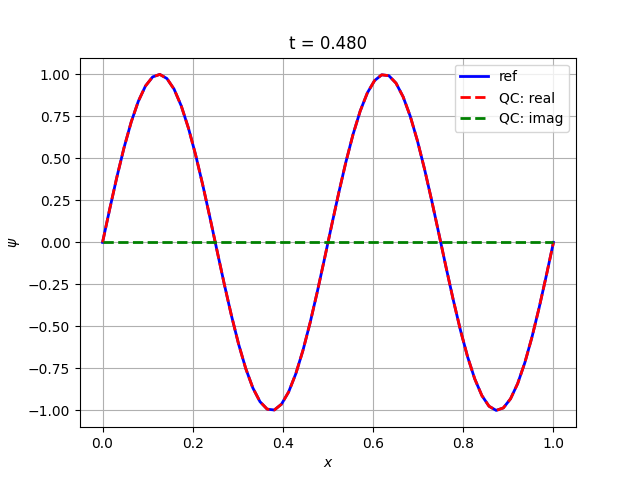

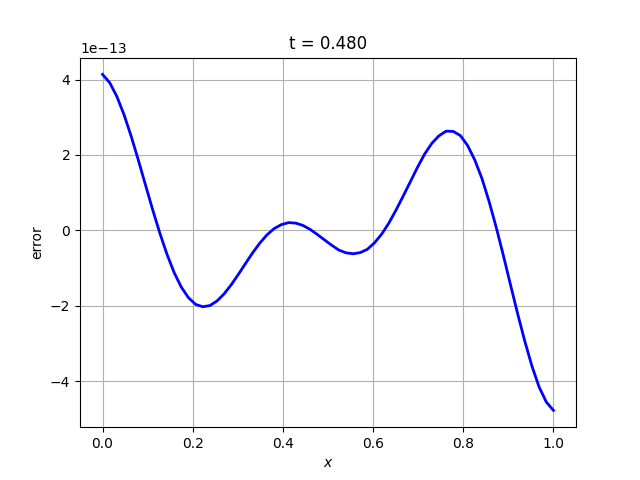

In [24]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------

# ------------------------------------------------------------------------------
def read_qc_data():
    print()  

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = "dc"
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    
    print("success prob: {:0.12e}".format(  np.sum(np.abs(qc_state)**2)  ))

    # --- renormalization due to the initialization ---
    qc_state *= 2**(nx/2.)

    # # renormalization:
    # om.read_qsvt()
    # Hadamart_norm_factor = 2**(nk_) 
    # coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    # qc_state *= coef_norm * (dk_ / np.pi)

    return qc_state
# ------------------------------------------------------------------------------
def compare_ref_qu(flag_save):

    y_ref_ch = psi_init
    # y_ref_ch = y_ref_compare_

    psi_qc = read_qc_data()

    # --- Compute the absolute error ---
    err_res = y_ref_ch - psi_qc.real

    # --- Compare the quantum state and the reference simulation ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y_ref_ch,    "-b",  linewidth = 2, label = "ref")
    ax.plot(x, psi_qc.real, "--r", linewidth = 2, label = "QC: real")
    ax.plot(x, psi_qc.imag, "--g", linewidth = 2, label = "QC: imag")
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    ax.legend()
    plt.title("t = {:0.3f}".format(t_LCHS_qucf_))
    plt.grid(True)
    plt.show()

    # --- Absolute error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, err_res, "-b", linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("error")
    plt.title("t = {:0.3f}".format(t_LCHS_qucf_))
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_DC_ref_{:s}.dat".format(name_pr_), 
            x, y_ref_compare_
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_DC_qc_{:s}.dat".format(name_pr_),  
            x, psi_qc.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_DC_err_{:s}.dat".format(name_pr_), 
            x, err_res
        )
    return
# ------------------------------------------------------------------------------
compare_ref_qu(flag_save = False)
